# Tutorial

In this section, the user can find a tutorial on how to use `EpiK` for inference of sequence-function relationships on a small dataset, how to interpret the inferred hyperparameters of the different kernels, and how to use `EpiK` to make calibrated phenotypic predictions in unobserved sequences.

### Import required libraries and functions

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from epik.utils import encode_seqs, split_training_test
from epik.model import EpiK
from epik.kernel import ConnectednessKernel, ExponentialKernel, JengaKernel

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Load SMN1 data

We will use a previously published dataset, in which the activity of nearly every possible GU/GC 5´splice site sequence was measured in parallel in a single experiment ([Wong et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30174293/)). The measured phenotype `y` is the percent spliced in, this is, the percentage of times exon 7 is included in the mature mRNA. The assay was performed in different biological replicates, providing a measure of uncertainty of our estimates given by `y_var`, as previously analyzed ([Zhou et al. 2022](https://pubmed.ncbi.nlm.nih.gov/36129941/))

We start by loading the data from the pre-processed CSV file

In [2]:
data = pd.read_csv('../data/smn1.csv', index_col=0)
data

,y,y_var
seq,,
AAACAAAA,0.223881,0.001738
AAACAAAC,0.514961,0.009195
AAACAAAG,0.208009,0.001500
AAACAAAU,0.235378,0.002109
AAACAACA,0.357162,0.004423
...,...,...
UUUUUUGU,0.199017,0.001373
UUUUUUUA,0.074571,0.000536
UUUUUUUC,0.193181,0.001294


### Prepare data for model fitting

`EpiK` models assume that sequences are provided in a one-hot encoding `X`, so we provide the utility function `encode_seqs` to generate this encoding from the raw sequences

In [3]:
X = encode_seqs(data.index.values, alphabet='ACGU')
y = data['y'].values
y_var = data['y_var'].values

We next split the data into training and test subsets with `split_training_test`. To keep this tutorial as simple and fast to run as possible, we will use only a small subset of the dataset for both training and testing.

In [4]:
splits = split_training_test(X, y, y_var, ptrain=0.075, dtype=torch.float32)
train_x, train_y, test_x, test_y, train_y_var = splits

# Subsample test data
idx = np.random.uniform(size=test_y.shape[0]) < 0.05
test_x, test_y = test_x[idx, :], test_y[idx]

### Fit Connectedness model regression

To define an `EpiK` model, we first need to specify the kernel function that we want to use for Gaussian process regression. In this case, we will use the `ConnectednessKernel`, in which the predictability of mutational effects decreases depending on the sites at which two sequences differ. 

As the number of parameters is equal to sequence length, this kernel provides a good compromise in datasets with relatively few measurements, such as this one. For every kernel class, we need to specify the configuration of sequence space, consisting of the number of alleles `n_alleles` and sequence length `seq_length`. 

In [5]:
kernel = ConnectednessKernel(n_alleles=4, seq_length=8)
model = EpiK(kernel, track_progress=True)
model.set_data(train_x, train_y, train_y_var)

After defining the `EpiK` model, we load the training data in the model and optimize the kernel hyperparameters by maximizing the marginal likelihood using the Adam optimizer for a number of predefined iterations. The argument `track_progress=True` allows us to follow the progress of the optimization and track how the loss function decreases

In [6]:
model.fit(n_iter=100, learning_rate=0.1)

Optimizing hyperparameters: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s, MLL=-8918.879, Mem(alloc/res)=0.00/0.00MB]


### Make predictions on test sequences

Once we have optimized the hyperparameters of the kernel function, we can make predictions by computing the posterior distribution over the sequence-function relationship evaluated at sequences of interest. This allows us to obtain point estimates `test_y_pred` that maximize this posterior probability. However, we can additionally compute the posterior variance `test_y_var` quantifying the uncertainty of the predictions by setting `calc_variance=True`. 

Lets now make predictions in the held-out test sequences. 

In [7]:
pred = model.predict(test_x, calc_variance=True)
pred

,coef,stderr,lower_ci,upper_ci
0,2.116530,12.501842,-22.887154,27.120216
1,1.571670,12.174002,-22.776333,25.919674
2,-0.843107,12.838286,-26.519680,24.833466
3,3.053030,12.459997,-21.866964,27.973024
4,-2.211174,12.297050,-26.805273,22.382925
...,...,...,...,...
1492,0.437592,12.282001,-24.126410,25.001593
1493,-2.043804,12.466360,-26.976524,22.888916
1494,-3.416660,12.331523,-28.079706,21.246386
1495,-0.705414,12.133599,-24.972612,23.561785


Once we have the predictions, we can compare them with the measurements for these held-out sequences. We can evaluate the accuracy of the point estimates by computing the $R^2$ and uncertainty calibration by calculating the percentage of times the measurement is within the 95% posterior predictive interval. 

In [8]:
r2 = pearsonr(pred['coef'], test_y)[0] ** 2
sd = pred['stderr']
obs = test_y.numpy()
calibration = ((obs > pred['coef'] - 2 * sd) & (obs < pred['coef'] + 2 * sd)).mean()

[Text(0.5, 0, 'Predicted PSI (%)'),
 (-20.0, 200.0),
 Text(0, 0.5, 'Measured PSI (%)'),
 (-20.0, 200.0),
 None]

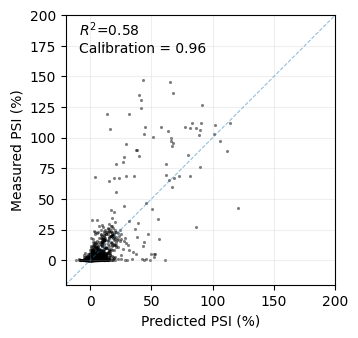

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3.5))
lims = (-20, 200)
axes.scatter(pred['coef'], obs, s=5, c='black', lw=0, alpha=0.5)
axes.plot(lims, lims, lw=0.75, linestyle='--', alpha=0.5)
axes.grid(alpha=0.2)
axes.text(0.05, 0.98, '$R^2$=' + '{:.2f}\nCalibration = {:.2f}'.format(r2, calibration),
          transform=axes.transAxes, ha='left', va='top')
axes.set(xlabel='Predicted PSI (%)', xlim=lims, 
         ylabel='Measured PSI (%)', ylim=lims, aspect='equal')

This scatterplot demonstrates the relatively good performance of the model in predicting the phenotype of held-out sequences in terms of $R^2$. Importantly, the model provides well-calibrated uncertainties, as the posterior distribution includes the actual measurements the expected number of times. This offers an estimate of how confident we can be about predictions for specific sequences with unknown phenotypes, aiding in decision-making.

### Compare different models

When analyzing a new dataset, we often want to fit different models and compare them. This is easy to do by just providing a different kernel to the `EpiK` model. Here, we fit models with kernels of increasing complexity and compute the $R^2$ of the predictions in held out data to track model performance. 

In [10]:
kernels = [ExponentialKernel, ConnectednessKernel, JengaKernel]
labels = ['Exponential', 'Connectedness', 'Jenga']
r2s = []
for label, kernel_type in zip(labels, kernels):
    kernel = kernel_type(n_alleles=4, seq_length=8)
    model = EpiK(kernel, track_progress=True, max_n_lanczos_iterations=200)
    model.set_data(train_x, train_y, train_y_var)
    model.fit(n_iter=100, learning_rate=0.1)
    test_y_pred = model.predict(test_x, calc_variance=False)['coef']
    r2s.append(pearsonr(test_y_pred, test_y)[0] ** 2)
results = pd.DataFrame({'kernel': labels, 'r2': r2s})
results

Optimizing hyperparameters: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, MLL=-8276.521, Mem(alloc/res)=0.00/0.00MB]


,kernel,r2
0,Exponential,0.559659
1,Connectedness,0.577626
2,Jenga,0.653812


Thus, this analysis shows that mutations at different sites affect the predictability of other mutations in a different manner, given the improved performance of the `ConnectednessKernel` over the `ExponentialKernel`. However, the `JengaKernel` provides even better predictive power, suggesting that the decay in predictability of mutational effects also depends on the specific alleles that are mutated at each site.

### Interpreting Jenga model parameters

Once we have settled with the Jenga model, we aim use the inferred hyperparameters of the kernel function to gain some insigths about the sequence-function relationship we are studying. We can extract the allele and site specific decay rates with the `get_decay_rates` method as follows

In [11]:
alleles = ['A', 'C', 'G', 'U']
positions = ['-3', '-2', '-1', '+2', '+3', '+4', '+5', '+6']
delta = kernel.get_delta().detach().numpy()
delta = pd.DataFrame(delta, index=positions, columns=alleles)
delta.loc['+2', ['A', 'G']] = np.nan
delta

,A,C,G,U
-3,0.020853,0.025342,0.438904,0.170491
-2,0.288113,0.039503,0.612494,0.129223
-1,0.076758,0.081544,0.820145,0.430954
+2,NaN,0.141537,NaN,0.713322
+3,0.774562,0.136644,0.406120,0.128953
+4,0.284240,0.052869,0.256599,0.123743
+5,0.016301,0.034593,0.713966,0.014079
+6,0.013091,0.012482,0.041129,0.073866


We can visualize these values in a heatmap

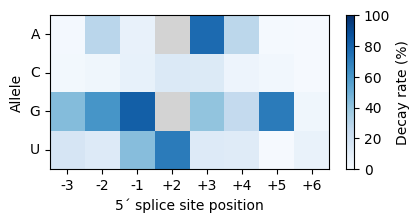

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(4.5, 2.))
axes.set_facecolor('lightgrey')
sns.heatmap(delta.T * 100, cmap='Blues', ax=axes,
            cbar_kws={'label': 'Decay rate (%)'},
            vmin=0, vmax=100)
axes.set(xlabel='5´ splice site position', 
         ylabel='Allele')
axes.set_yticklabels(alleles, rotation=0)
sns.despine(left=False, bottom=False, top=False, right=False)

The decay rate of a mutation is the percent decrease in the predictability of other mutatiob. These effects are constant and thus accumulate as discount coupons when two sequences differ by sevelal mutations. In the Jenga model, a mutation decreases the predictability of other mutations by accumulating the decay rates associated to the alleles that are exchanged. Next, we show examples of mutations, even at the same position, that have very different effects on the predictability of other mutations under this prior. 

In [14]:
d = (1 - (1 - delta.loc['-1', 'G']) * (1 - delta.loc['-1', 'U'])) * 100
print('For instance, a G-1U mutation is expected to decrease the predictability of other mutations by {:.2f}%'.format(d))

For instance, a G-1U mutation is expected to decrease the predictability of other mutations by 89.77%


In [15]:
d = (1 - (1 - delta.loc['-1', 'A']) * (1 - delta.loc['-1', 'C'])) * 100
print('In contrast, a mutation at the same position, A-1C, is expected to decrease the predictability of other mutations by only {:.2f}%'.format(d))

In contrast, a mutation at the same position, A-1C, is expected to decrease the predictability of other mutations by only 15.20%


In general, we see that the positions close to the exon-intron boundary, which are known to be more relevant for the recognition of the 5´splice site during the splicing reaction, have stronger decay factors. But we also see that, within each position, alleles with weak decay factors are more likely to be generally exchangeable without affecting the effects of other mutations. 